Exercise 3: Do an image denoising example using Markov Random Fields like that shown in class.

I have taken an image and converted all the pixel values to a value between {-1, 1}. Then I have flipped the values, with probability of 0.1 to add noise to the image. 

### Markov Random Field For Image Denoising

Because the noise level is small, we know that there will be a strong correlation between $x_i$ and $y_i$. We also know that neighbouring pixels $x_i$ and $x_j$ in an image are strongly correlated. This prior knowledge can be captured using the Markov random field model whose undirected graph is shown in above figure. This graph has two types of cliques, each of which contains two variables. The cliques of the form $\{x_i, y_i\}$ have an associated energy function that expresses the correlation between these variables. We choose a very simple energy function for these cliques of the form $- \eta x_i y_i$ where $\eta$ is a positive constant. This has the desired effect of giving a lower energy (thus encouraging a higher probability) when $x_i$ and $y_i$ have the same sign and a higher energy when they have the opposite sign.

The remaining cliques comprise pairs of variables $\{x_i, x_j\}$ where $i$ and $j$ are indices of neighbouring pixels. Again, we want the energy to be lower when the pixels have the same sign than when they have the opposite sign, and so we choose an energy given by $− \beta x_i x_j$ where $\beta$ is a positive constant.

Because a potential function is an arbitrary, nonnegative function over a maximal clique, we can multiply it by any nonnegative functions of subsets of the clique, or equivalently we can add the corresponding energies. In this example, this allows us to add an extra term $\alpha x_i$ for each pixel $i$ in the noise-free image. Such a term has the effect of biasing the model towards pixel values that have one particular sign in preference to the other.

The complete energy function for the model then takes the form

$$E(X,Y) = \alpha\sum\limits_{i} x_i - \beta \sum\limits_{i,j} x_i x_j - \eta \sum\limits_{i} x_i y_i $$

which deﬁnes a joint distribution over $x$ and $y$ given by

$$p(x, y) = \frac{1}{Z} \exp\{-E(x,y)\}$$

### Idea to solve the problem

Basic idea to solve this problem is updating the noisy image to decrease it's energy function. It's essentially an optimization process. A general way to do that is finding the gradient of energy function and modify original data according to it. We call this method **gradient descent**. 

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2d
import cv2

In [3]:
def showImage(image):
    plt.imshow(image, cmap='gray')
    plt.show()

In [4]:
def convertPixels(image):
    image_gray = image.copy()
    for i in range(0, image.shape[0]):
        for j in range(0, image.shape[1]):
            if image_gray[i][j] == 0:
                image_gray[i][j] = -1
    return image_gray

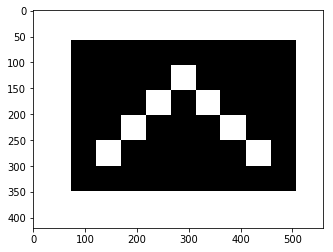

In [5]:
image = plt.imread('image.png')
showImage(image)

In [6]:
image = image[:,:,0]
image_gray = convertPixels(image)

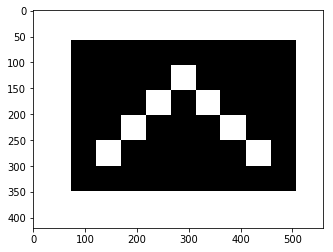

In [7]:
#Displaying the image with pixel values between -1 and 1
showImage(image_gray)

In [40]:
def addNoise(new_image):
    index = np.random.rand(image.shape[0], image.shape[1])
    print(index.dtype)
    new_image[index < 0.1] *= 1
    return new_image

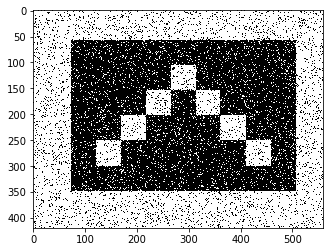

In [9]:
noise_image = addNoise(image_gray)
showImage(noise_image)

In [10]:
def energyFunction(hidden, observation, alpha=1, beta=1, gamma=1, phi=1, sigma=1, eta=1):
    beta_filter = np.array([[0.0, 1.0, 0.0], [1.0, 0.0, 1.0], [0.0, 1.0, 0.0]])
    #Convolve the image with the beta_filter
    matB = conv2d(hidden, beta_filter, 'same')
    #Calculating the energy map
    mapE = hidden * (alpha - beta * matB - eta * observation)
    #Calculate the energy
    E = np.mean(mapE)
    #Calculate the energy difference map
    dE = -2 * mapE
    return E, dE

In [11]:
def denoise(noisy_image, efunc, alpha, beta, gamma, phi, sigma, eta):
    rec_image = noisy_image.copy()
    #Calculating Energy and its gradients
    E, dE = efunc(rec_image, noisy_image, alpha, beta, gamma, phi, sigma, eta)
    #Temporal energy and iteration count
    Etmp, i = E + 1, 0
    # optimize the energy function
    while Etmp > E:
        Etmp = E
        # Flipping the pixels which can lower the Energy function
        rec_image[dE < 0] *= -1
        # Calculate energy function with revised image
        [E, dE] = efunc(rec_image, noisy_image, alpha, beta, gamma, phi, sigma, eta)
        i += 1
    rec_image[rec_image == -1] == 0
    return rec_image
        
    

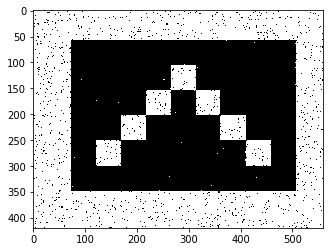

In [12]:
denoised_image = denoise(noise_image, energyFunction, 1, 1, 1, 1, 1, 1)
showImage(denoised_image)

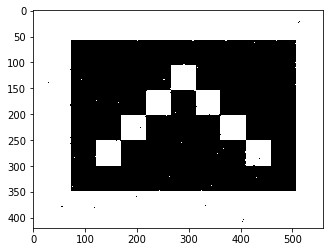

In [13]:
denoised_image = denoise(noise_image, energyFunction, 0, 1, 1, 1, 1, 0)
showImage(denoised_image)

In [14]:
def extendedEnergyFunction(hidden, observation, alpha, beta, gamma, phi, sigma, eta):
    #The different templates
    # template alpha
    Ta = np.asarray([[[-1,-1,-1,-1,1],[-1,-1,-1,1,-1],[-1,-1,0,-1,-1],[-1,1,-1,-1,-1],[1,-1,-1,-1,-1]],
                     [[-1,-1,1,-1,-1],[-1,-1,1,-1,-1],[-1,-1,0,-1,-1],[-1,-1,1,-1,-1],[-1,-1,1,-1,-1]],
                     [[1,-1,-1,-1,-1],[-1,1,-1,-1,-1],[-1,-1,0,-1,-1],[-1,-1,-1,1,-1],[-1,-1,-1,-1,1]],
                     [[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1],[1,1,0,1,1],[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1]]])
    # template beta
    Tb = np.asarray([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
    # template gamma
    Tg = np.asarray([[1,1,1,1,1],[1,0,0,0,1],[1,0,0,0,1],[1,0,0,0,1],[1,1,1,1,1]])
    # template phi
    Tp = np.asarray([[0,0,1,0,0],[0,0,1,0,0],[1,1,0,1,1],[0,0,1,0,0],[0,0,1,0,0]])
    # template sigma
    Ts = np.asarray([[[1,-1,-1,-1,-1],[1,0,-1,-1,-1],[1,1,0,-1,-1],[1,1,1,0,-1],[1,1,1,1,1]],
                     [[1,1,1,-1,-1],[1,1,0,-1,-1],[1,1,0,-1,-1],[1,1,0,-1,-1],[1,1,1,-1,-1]],
                     [[1,1,1,1,1],[1,1,1,0,-1],[1,1,0,-1,-1],[1,0,-1,-1,-1],[1,-1,-1,-1,-1]],
                     [[1,1,1,1,1],[1,1,1,1,1],[1,0,0,0,1],[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1]],
                     [[1,1,1,1,1],[-1,0,1,1,1],[-1,-1,0,1,1],[-1,-1,-1,0,1],[-1,-1,-1,-1,1]],
                     [[-1,-1,1,1,1],[-1,-1,0,1,1],[-1,-1,0,1,1],[-1,-1,0,1,1],[-1,-1,1,1,1]],
                     [[-1,-1,-1,-1,1],[-1,-1,-1,0,1],[-1,-1,0,1,1],[-1,0,1,1,1],[1,1,1,1,1]],
                     [[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1],[1,0,0,0,1],[1,1,1,1,1],[1,1,1,1,1]]])
   

    #Generating parameter for alpha
    matA = np.empty(hidden.shape)
    for T in Ta:
        matA = np.maximum(matA, hidden * conv2d(hidden, T, 'same'))
        
    #Generating parameter matrix beta
    matB = conv2d(hidden, Tb, 'same')
    
    #Generating parameter matrix for gamma
    matG = conv2d(hidden, Tg, 'same')
    
    #Generating paraameter matrix for phi
    matP = conv2d(hidden, Tp, 'same')
    
    #Generating parameter for sigma
    matS = np.empty(hidden.shape)
    for T in Ts:
        matS = np.maximum(matS, hidden * conv2d(hidden, T, 'same'))
        
    #calculate energy map
    mapE = -alpha*matA - sigma * matS - hidden * ( beta*matB + gamma*matG + phi*matP + eta*observation)
    
    #Energy value as mean of mapE
    E = np.mean(mapE)
    
    #Energy difference
    dE = -2 * mapE
    
    return E, dE

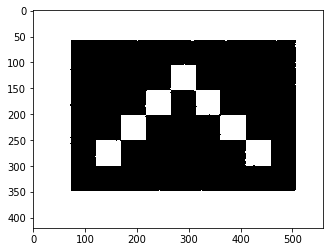

In [15]:
denoised_image = denoise(noise_image, extendedEnergyFunction, 0, 1, 0.1, 0, 0.1, 0)
showImage(denoised_image)

Experiment with a low definition image - 

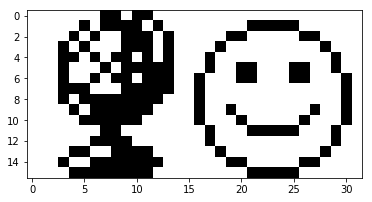

In [16]:
image = plt.imread('happyworld.png')
showImage(image)

In [17]:
print(image.shape)
image_gray = convertPixels(image)

(16, 32)


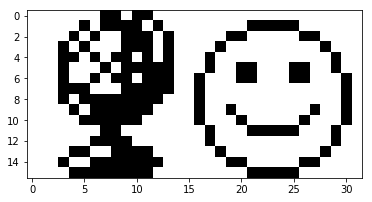

In [18]:
showImage(image_gray)

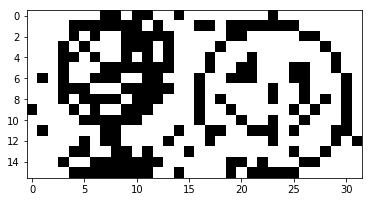

In [19]:
noise_image = addNoise(image_gray)
showImage(noise_image)

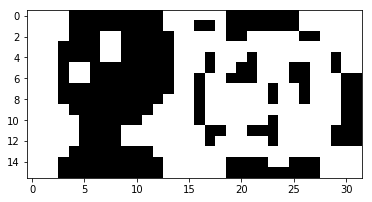

In [20]:
denoised_image = denoise(noise_image, energyFunction, 1, 1, 1, 1, 1, 1)
showImage(denoised_image)

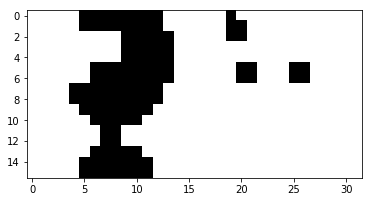

In [21]:
denoised_image = denoise(noise_image, energyFunction, 0, 1, 1, 1, 1, 0)
showImage(denoised_image)

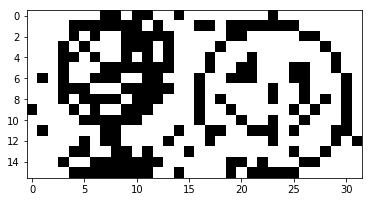

In [23]:
denoised_image = denoise(noise_image, extendedEnergyFunction, 0, 1, 0.1, 0, 0.1, 0)
showImage(denoised_image)

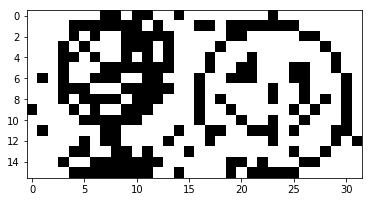

In [24]:
denoised_image = denoise(noise_image, extendedEnergyFunction, 0, 0.1, 0.1, 0.1, 1, 1)
showImage(denoised_image)

As you can see this method of denoiseing the image doesn't work out well for images which have low resolution. Then tend to destroy the whole image.

### Denoising a colored image

We have seen how to denoise a back and white image below I have implemented an extension of this for coloured images.

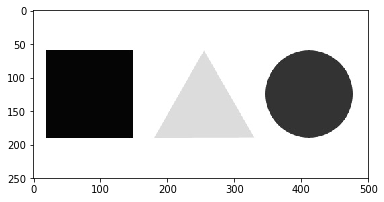

In [52]:
image = cv2.imread('color.jpg', 0)
showImage(image)

(250, 500)


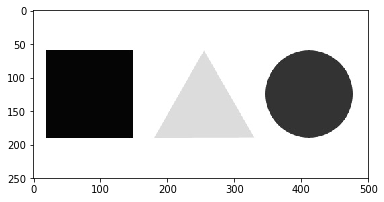

[[255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 ..., 
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]]
[[ 0.04472136  0.04472136  0.04472136 ...,  0.04472136  0.04472136
   0.04472136]
 [ 0.04472136  0.04472136  0.04472136 ...,  0.04472136  0.04472136
   0.04472136]
 [ 0.04472136  0.04472136  0.04472136 ...,  0.04472136  0.04472136
   0.04472136]
 ..., 
 [ 0.04472136  0.04472136  0.04472136 ...,  0.04472136  0.04472136
   0.04472136]
 [ 0.04472136  0.04472136  0.04472136 ...,  0.04472136  0.04472136
   0.04472136]
 [ 0.04472136  0.04472136  0.04472136 ...,  0.04472136  0.04472136
   0.04472136]]
float64


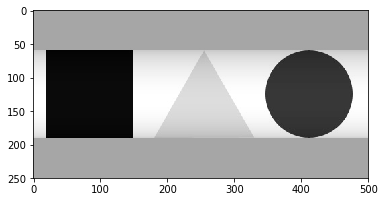

In [60]:
from sklearn.preprocessing import normalize 
#image = np.array(image, dtype='uint8')
#dt = np.dtype(image)
#image = image[:,:,0]
print(image.shape)
image = convertPixels(image)
showImage(image)
print(image)
norm_img = normalize(image)
print(norm_img)
noise_image = addNoise(norm_img)
showImage(noise_image)

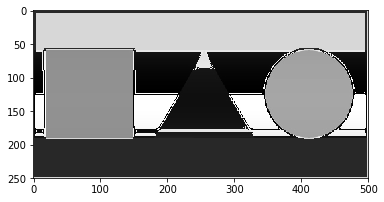

In [62]:
denoised_image = denoise(noise_image, extendedEnergyFunction, 1, 1, 0.1, 0, 0.1, 0)
showImage(denoised_image)

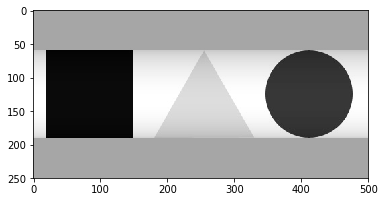

In [64]:
denoised_image = denoise(noise_image, extendedEnergyFunction, 1, 1, 0.1, 0, 1, 0)
showImage(denoised_image)

As you can see this doesn't work very well with colored images.